In [1]:
import numpy as np
import pandas as pd
import math
import folium
from folium.plugins import FloatImage
import os
from PIL.ExifTags import TAGS, GPSTAGS
from plotly.subplots import make_subplots
from PIL import Image, ImageDraw, ImageFont

### Acronomy
- acceleration in 1s time interval: $accel$
- $S_ij $: speed at i elapsed time and j elapsed time inside i and i+1 interval<br>
- $Lat_i$: latitude of i point <br>
- $Lon_i$: longitude of i point <br>
- $t_i$: time at i point  <br>
- SR: Sampling rate of accelerations, 200Hz in this case <br>

In [2]:
DF = os.getcwd()
df_Loc = pd.read_csv(os.path.join(DF, 'Location.csv'))
df_Loc.index = pd.to_datetime(df_Loc['time'], unit='ns')

In [3]:
df_Vibr = pd.read_csv(os.path.join(DF, 'Accelerometer.csv'))
df_Vibr.index = pd.to_datetime(df_Vibr['time'], unit = 'ns')

### Trim Location data to allow 20s GPS stabalization. And
### Match vibration data with GPS data based on time

In [4]:
# cur first 20 seconds as stable time 
df_Loc = df_Loc[df_Loc.index >= df_Vibr.index[0]+pd.Timedelta(seconds=20)]
print('Start point of analysis ', df_Loc.index[0])

# Trim the data to make vibration and GPS data match
if df_Vibr.index[0] < df_Loc.index[0]:
    df_Vibr = df_Vibr[df_Vibr.index >= df_Loc.index[0]]
else:
    df_Loc = df_Loc[df_Loc.index >= df_Vibr.index[0]]
    
print('Shape of Vibration data ', df_Vibr.shape)
print('Shape of Location data ', df_Loc.shape)


Start point of analysis  2023-04-17 11:30:28.999912400
Shape of Vibration data  (102143, 5)
Shape of Location data  (1018, 12)


### sometimes sampling rate of GPS changes, the vibration data will somehow change as well. This will affect the calculation of sampling rate of accelerometor. To avoid that, following codes will drop all data after identifying change of SR of GPS

In [5]:
for i in range(1,df_Loc.shape[0]):
    if (df_Loc.index[i]-df_Loc.index[i-1]).total_seconds()>2:
        df_Loc = df_Loc[df_Loc.index <= df_Loc.index[i-1]]
        index_temp = np.abs((df_Vibr.index - df_Loc.index[i-1])).argsort()[0]
        df_Vibr4SR = df_Vibr.iloc[0:index_temp]
        break
    else:
        df_Vibr4SR = df_Vibr

In [6]:
df_Loc.shape

(1018, 12)

In [7]:
df_Vibr.shape

(102143, 5)

### Calculate the sampling rate
#### It is been found that the max sampling rate for most of smarphones remain unknown, it can only be found by test. the data processing layer should be able to process data with unknown sampling rate
#### round_down(vib.len/timeSpan)

In [8]:
Time_Span = df_Vibr4SR.index[-1]-df_Vibr4SR.index[0]
print('Time duration', Time_Span.total_seconds())
SR = int(df_Vibr4SR.shape[0]/Time_Span.total_seconds())
print('Sampling rate is ', SR)

Time duration 1017.33504
Sampling rate is  100


In [9]:
df_Vibr.shape[0]/Time_Span.total_seconds()

100.40251832867173

In [10]:
df_Vibr.shape[0]/Time_Span.total_seconds()

100.40251832867173

### As shown above, the length of vibr data and loc data do not match
In any smartphone, the sampling rate of vibration data is not exact integers, e.g. if Sampling rate (SR) is 100Hz and 1000s duration for data collection, 100300 vibration data might be collected. the SR error is 0.3% or more. For 1000s, 300 data points error is equivilent to 3s error. In GIS, if the vehicle runs 10m/s, the error can be 30m. <br>

#### Same error happens on GPS

### To eliminate above errors
We take GPS as fiducial values. <br>
Firstly, find time in Vibr data that matches all rows with Loc data. <br>
Secondly, between every two GPS data points, we assign (SR-1) GPS data to vibration data points accordingly.<br>
Thirdly, concatenate all into one array <br>
Finally, Trim extra data points that beyond SR*[length(Loc)-1] in vibration data <br>
<br>
In this way, we keep the length of the vibra data exactly SR*length of loc without lossing too many data points

In [11]:
Vibr_BL2_Loc = [] # there will be dropoff
Vibr_BL2_Locpf = pd.DataFrame()
for i in df_Loc.index:
    index_temp = np.abs((df_Vibr.index - i)).argsort()[0]
    temp = df_Vibr.iloc[index_temp:index_temp+SR]
    Vibr_BL2_Loc.append(temp)
    Vibr_BL2_Locpf = pd.concat([Vibr_BL2_Locpf,temp],axis=0)
Vibr_BL2_Locpf = Vibr_BL2_Locpf[0:SR*(df_Loc.shape[0]-1)]

In [12]:
print('Number of the vibr data beyond last location data is', Vibr_BL2_Loc[-1].shape[0])
print('Shape of the new vibration data is ', Vibr_BL2_Locpf.shape)
print('Length of the location data is ', len(Vibr_BL2_Loc))

Number of the vibr data beyond last location data is 35
Shape of the new vibration data is  (101700, 5)
Length of the location data is  1018


### Compare original vibra data and dropoff vibra data

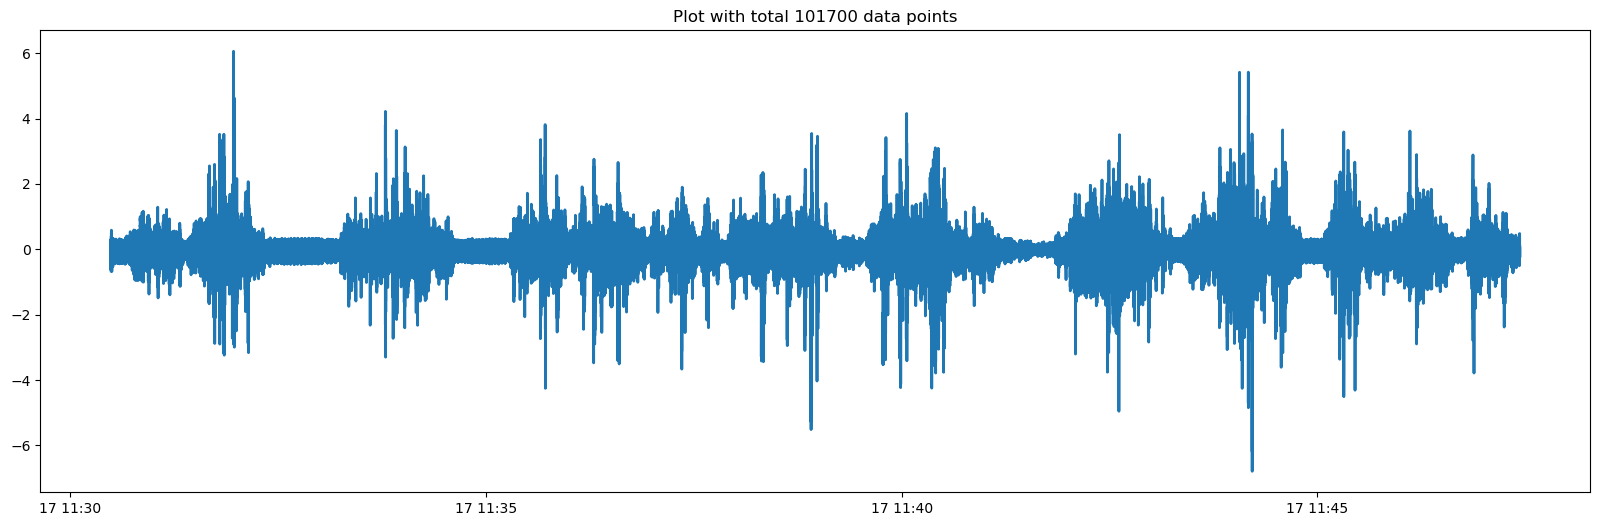

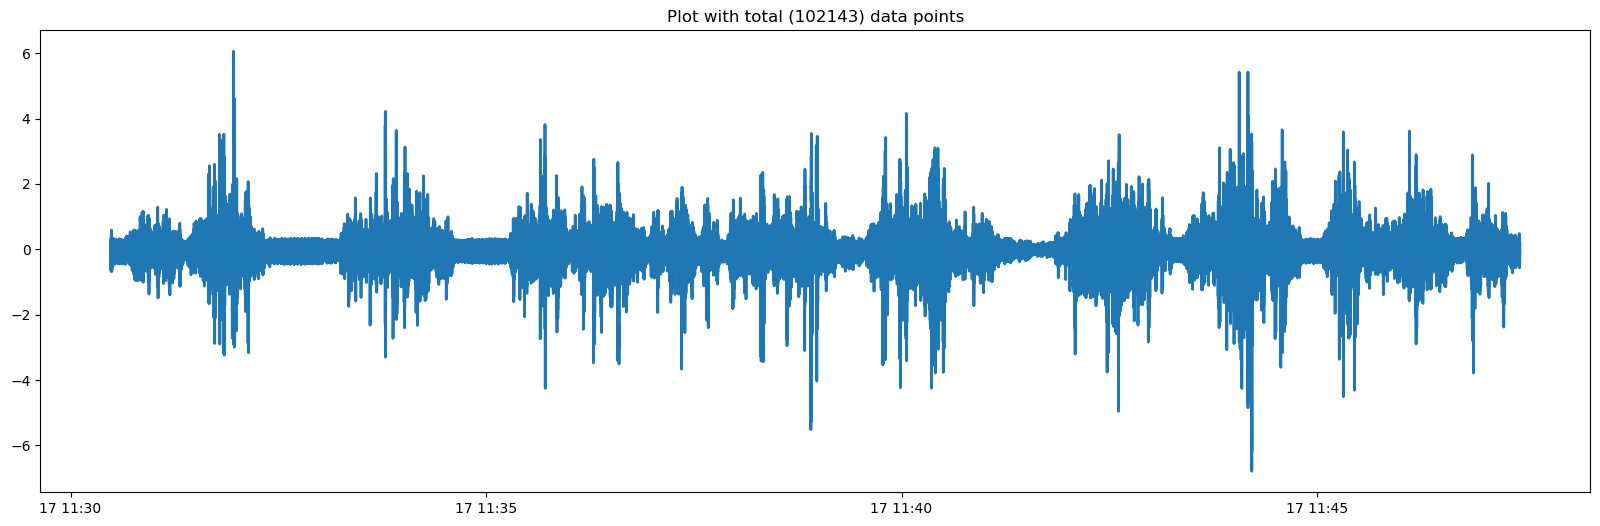

In [13]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
for axis in ['z']:
    plt.plot(Vibr_BL2_Locpf.index, Vibr_BL2_Locpf[axis],color='C0', linewidth=2)
plt.title(f"Plot with total {Vibr_BL2_Locpf.shape[0]} data points")
plt.show()

for axis in ['z']:
    plt.plot(df_Vibr.index, df_Vibr[axis],color='C0', linewidth=2)
plt.title(f"Plot with total ({df_Vibr.shape[0]}) data points")
plt.show()

In [14]:
speed = df_Loc['speed']

-1 mean no valid speed data available, replace all -1 by 0

In [15]:
speed = speed.replace(-1,0) # In GPS, -1 represents speed of 0

In [16]:
Lat = df_Loc['latitude']
Lon = df_Loc['longitude']

### To draw vibra data against GPS data, two dataset should have the same length. 
### However, 
--- The sampling rate of GPS is always 1Hz, namely 1 sampling per second, this is the property of the satalite rather than smartphones

--- And the sampling rate of accelerometer is 100Hz or more

#### More Loc data should be generated


### How does it work?

--- between every two second interval, location data will be generated for each vibration data based on the distance of each vibration data to the reference GPS points. 

--- as the speed of vehicle can be changing in every two seconds interval, the density of vibration data can be unenven, i.e. the vibration data points is not evenly distributed.

#### assumptions
-  We assume the acceleration of vehicle is constant within every 1s interval.
-  We assume the road is straight in 1s interval.

#### Calculate the distance to i0 for all ij points.
-  The speed change,i.e. acceleration, at each elapsed time is written as accel = [$S_i-(S_i+ΔS)$]/SR
-  the speed at each elapsed time is $S_ij = S_i0+j*accel$
-  the average speed between j and j+1 in 1s interval is {$S_ij$+$S_ij+1$}/2
-  Finaly we calculate the distance of ij to i0, $\Sigma$ {$S_i0+j*[S_i-(S_i+ΔS)]/SR+S_i0+(j+1)*[S_i-(S_i+ΔS)]$/SR}/2 


In [17]:
def DisIn1s(S0,Td,SR):
    S1 = 2*Td/1-S0
    accel = (S1-S0)/(SR)
    Dis2S0List = [0]
    Dis2S0 = 0
    for j in range (0,SR-1):
        aver = ((S0+(j+1)*accel)+(S0 + j*accel))/2
        DisTra = aver*(1/SR)
        Dis2S0 = Dis2S0+DisTra
        Dis2S0List.append(Dis2S0)
    return Dis2S0List

In [18]:
def HaversineFormula(location1, location2):
    earth_radius = 6371000
    lat1, lon1 = location1
    lat2, lon2 = location2
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    d_lat = lat2 - lat1
    d_lon = lon2 - lon1
    # Apply the Haversine formula
    a = math.sin(d_lat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(d_lon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    d = earth_radius * c
    bearing = math.atan2(math.sin(d_lon)*math.cos(lat2), math.cos(lat1)*math.sin(lat2) - math.sin(lat1)*math.cos(lat2)*math.cos(d_lon))
    return earth_radius * c, bearing

In [19]:
def NewLoc(loc1,loc2,initial_speed,SR):
    lat_A,lon_A = loc1
    lat_B,lon_B = loc2
    Dlist = []
    TotalDist, bearing = HaversineFormula((lat_A, lon_A), (lat_B, lon_B))
    Dis2S0List = DisIn1s(initial_speed,TotalDist,SR)
    R = 6371000
    for i in range(SR):
        # Calculate the distance and bearing from A to the current GPS location
        distance = Dis2S0List[i]
        # Calculate the latitude and longitude of the current GPS location
        lat1 = math.radians(lat_A)
        lon1 = math.radians(lon_A)
        lat2 = math.asin(math.sin(lat1)*math.cos(distance/R) + math.cos(lat1)*math.sin(distance/R)*math.cos(bearing))
        lon2 = lon1 + math.atan2(math.sin(bearing)*math.sin(distance/R)*math.cos(lat1), math.cos(distance/R)-math.sin(lat1)*math.sin(lat2))
        lat_cur = math.degrees(lat2)
        lon_cur = math.degrees(lon2)
        Dlist.append((lat_cur,lon_cur))

    return Dlist

In [20]:
Loc4Vib = []
for i in range (len(Lat)-1):
    testS1 = speed[i]
    LocTes1 = (Lat[i],Lon[i])
    LocTes2 = (Lat[i+1],Lon[i+1])
    LocList = NewLoc(LocTes1,LocTes2,testS1,SR)
    Loc4Vib.extend(LocList)

In [21]:
print('length of the new location data ', len(Loc4Vib))
print('shape of the vibration data matrix', Vibr_BL2_Locpf.shape)

length of the new location data  101700
shape of the vibration data matrix (101700, 5)


### Now draw vibration data against GPS data
#### GPS data is 2D map, so Vibra vs GPS is 3D. with such a large dataset, this 3D plot will be a mass.
#### The alternative solution is to draw vibration data vs accumulative distance, i.e. the distances of each vibra data on the route
#### Now lets calculate the accumulated distance corresponding to every vibra data point. 

In [22]:
Loc4Vib[0]

(51.87713370700943, -8.484926999930467)

In [23]:
AcDist = np.array([0])

temp_Dist = 0
for i in range(1,len(Loc4Vib)):
    stgtDist, bearing = HaversineFormula(Loc4Vib[i-1], Loc4Vib[i])
    temp_Dist += stgtDist
    AcDist = np.append(AcDist, temp_Dist)
print('The total distance of the route', AcDist[-1])

The total distance of the route 5790.366167611488


In [24]:
AcDist.shape

(101700,)

### Now draw Vibra vs Distance

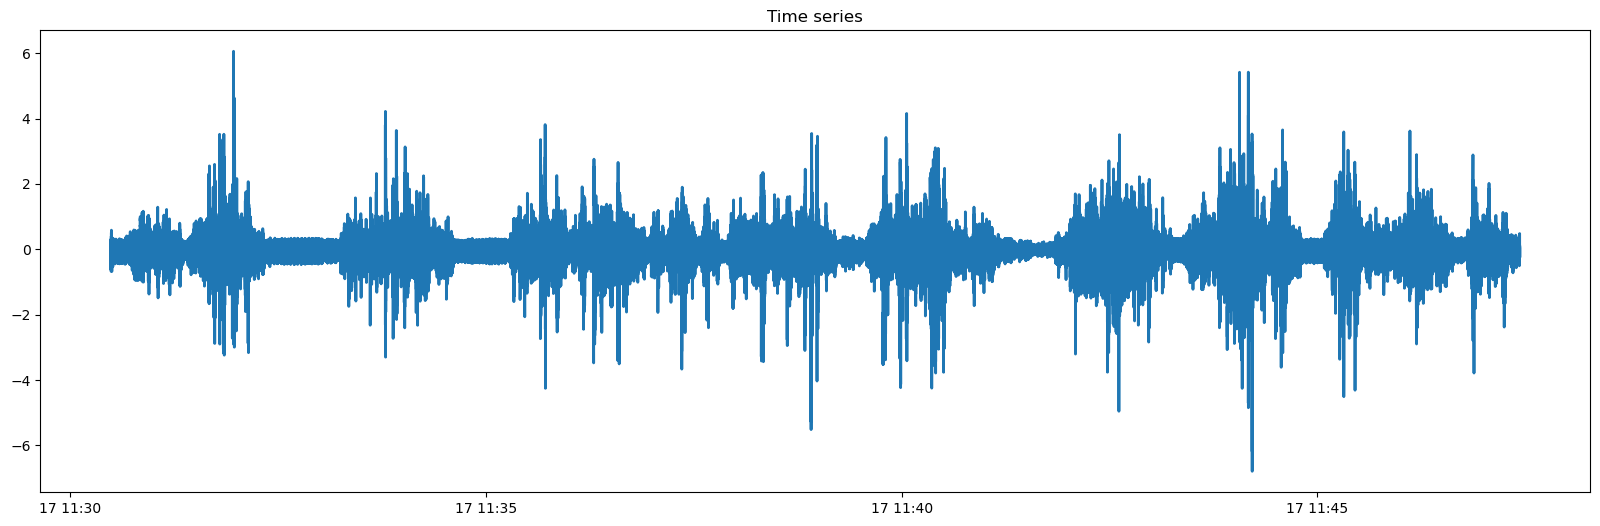

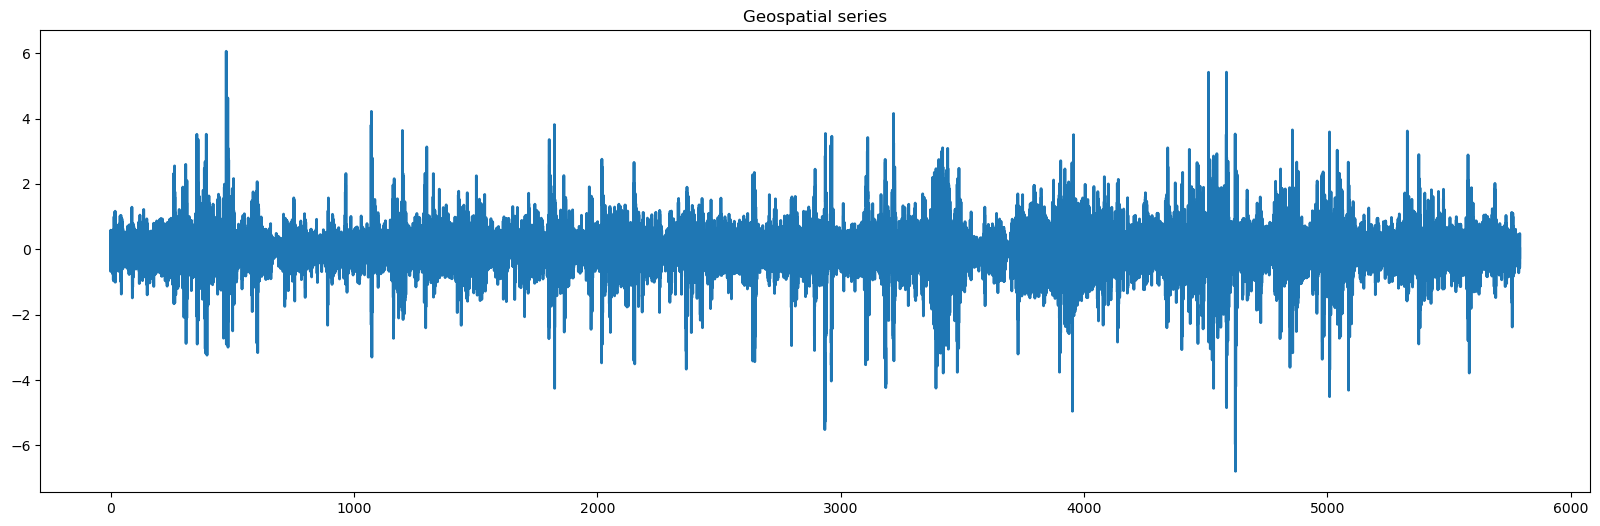

In [25]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,6)
for axis in ['z']:
    plt.plot(Vibr_BL2_Locpf.index, Vibr_BL2_Locpf[axis],color='C0', linewidth=2)
plt.title("Time series")
plt.show()

for axis in ['z']:
    plt.plot(AcDist, Vibr_BL2_Locpf[axis],color='C0', linewidth=2)
plt.title("Geospatial series")
plt.show()


In [26]:
AcDist.shape

(101700,)

### Now save new data to file

In [27]:
NLocations = pd.DataFrame(Loc4Vib, columns=['Latitude', 'Longitude'])
AccumulativeDist = pd.DataFrame(AcDist, columns=['AccumulativeDist'])

In [28]:
NLocations.index

RangeIndex(start=0, stop=101700, step=1)

In [29]:
Vibr_BL2_Locpf = Vibr_BL2_Locpf.reset_index(drop=True)
Vibr_BL2_Locpf.index

RangeIndex(start=0, stop=101700, step=1)

In [30]:
AllinOne = pd.concat([Vibr_BL2_Locpf, NLocations,], axis=1)

# Visualization

In [31]:
# convert GPS 
def GPSdegree2decimal(N,W):
    latitude_decimal = N[0] + (N[1]/60.0) + (N[2]/3600.0)
    longitude_decimal = W[0] + (W[1]/60.0) + (W[2]/3600.0)
    return latitude_decimal, -longitude_decimal

In [32]:
# Load the image
def readImagGPS(path):
    image_path = path
    image = Image.open(image_path)
    longi, lati = 0,0
    # Extract metadata
    exifdata = image._getexif()
    ImagGPS = {}

    for tag, value in exifdata.items():
        decoded = TAGS.get(tag,tag)
        if decoded == 'GPSInfo':
            GPSdata = {}
            for subtag in value:
                subdecoded = GPSTAGS.get(subtag,subtag)
                GPSdata[subdecoded] = value[subtag]

            ImagGPS[decoded] = GPSdata
    DecimalGPS = list(GPSdegree2decimal(ImagGPS['GPSInfo']['GPSLatitude'], ImagGPS['GPSInfo']['GPSLongitude']))  
    df = pd.DataFrame(data=ImagGPS)
    df = df.fillna(' ').T
    df = df.applymap(lambda x: x[0] if type(x)==list else x)
    df.to_html()
    return df, DecimalGPS


In [33]:
def readFolder (path):
    folder_path = path
    Files =[]
    # Define a list of image file extensions
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        # Check if the file is an image file
        if os.path.isfile(file_path) and any(ext in filename.lower() for ext in image_extensions):
            # Open the image file using the PIL library
            Files.append(filename)
    
    return Files

In [34]:
def addtoFoliumMap(map,imageURL):
    info, GPSloc = readImagGPS(imageURL)
    
    TempInfo = "Anomaly type: Patching <br />Catagary: 4 <br /> Latitude: 51.87936111 <br /> Longitude: 8.30510833"
    htmlcode = """<div>
    <img src={imageURL} alt={info} width="230" height="172">
    <br /><span style="font-size: 12px">{info}</span>
    </div>""".format(**locals())
    tooltip = "Click me!"

    folium.Marker(
        [GPSloc[0], GPSloc[1]], popup=htmlcode, tooltip=tooltip
    ).add_to(map)

In [35]:
dir_path = os.getcwd()
Images = readFolder (dir_path)
ImgLoc = []
metadata = []
for item in Images:
    df, DecimalGPS = readImagGPS(item)
    ImgLoc.append(DecimalGPS)
    metadata.append(metadata)

In [ ]:
Index_ImgLoc = []
check_dist = []
for matchingC in ImgLoc:
    temdist = []
    for allC in Loc4Vib:
        distance, bearing = HaversineFormula(allC, matchingC)
        temdist.append(distance)    
    miniDis = min(temdist)
    Index_ImgLoc.append(temdist.index(miniDis))
    check_dist.append(miniDis) 
    
Time_ImgLoc = AcDist[Index_ImgLoc]


In [ ]:
fig, ax = plt.subplots()

for axis in ['z']:
    ax.plot(AcDist, Vibr_BL2_Locpf[axis],color='C0', linewidth=2, label ='Vibrations',zorder=1)
ax.scatter(Time_ImgLoc,len(Time_ImgLoc)*[0], color='r', label = 'Location of Images',zorder=2)
ax.set_title("Geospatial series")
plt.show()


### define a window size and calculate each windows standard derivation

In [ ]:
WdSize = 3 # in meters
dist = WdSize
MarkingMap = Vibr_BL2_Locpf.copy()
while dist < AcDist[-1]:
    wd = (AcDist > dist) & (AcDist < dist+WdSize)
    sd = np.std(Vibr_BL2_Locpf.z[wd])
    MarkingMap.z[wd] = sd
    dist+=WdSize

In [ ]:
import branca.colormap

minm = np.min(MarkingMap.z)
maxm = np.max(MarkingMap.z)

colormap = branca.colormap.linear.YlOrRd_09.scale(minm,maxm).to_step(6)

my_map = folium.Map(location=[51.88270833333333, -8.496402777777776], zoom_start=13)

dir_path = os.getcwd()
Images = readFolder (dir_path)
folium.ColorLine(positions=Loc4Vib, colormap=colormap, weight=10, colors=MarkingMap.z).add_to(my_map)

for item in Images:
    addtoFoliumMap(my_map,item)
    
my_map
# my_map.save("test_map.html")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some sample data
x = np.linspace(0, 10, 100)
y_plot = np.sin(x)
y_scatter = np.cos(x)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the line
ax.plot(x, y_plot, label='Plot')

# Scatter points
ax.scatter(x, y_scatter, color='red', label='Scatter')

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('Plot and Scatter in the Same Graph')

# Display legend
ax.legend()

# Show the plot
plt.show()